
A board game is a tabletop game that involves counters or pieces moved or placed on a pre-marked surface or "board", according to a set of rules. Some games are based on pure strategy, but many contain an element of chance; and some are purely chance, with no element of skill.
A popular site where these types of board games are discussed and reviewed is [BoardGameGeek](https://www.boardgamegeek.com/).

In this project, I apply machine learning to predict average_rating using the other columns such as playing-time, minimum recommended age, number of players etc. 

This data set contains 80000 board games and their associated review scores. The data was scraped from [BoardGameGeek](https://www.boardgamegeek.com/) and compiled into CSV format by [Sean Beck](https://github.com/ThaWeatherman). The data set is stored in board_games.csv, and can be downloaded here.

Here are some of the interesting columns:

- name: name of the board game.
- playingtime: the playing time (given by the manufacturer).
- minplaytime: the minimum playing time (given by the manufacturer).
- maxplaytime: the maximum playing time (given by the manufacturer).
- minage: the minimum recommended age to play.
- users_rated: the number of users who rated the game.
- average_rating: the average rating given to the game by users. (0-10)
- total_weights: Number of weights given by users. Read more about what BoardGameGeek considers weights here.
- average_weight: the average of all the subjective weights (0-5).


[Download the dataset here](https://www.boardgamegeek.com/)

[View the project on DataQuest](https://www.dataquest.io/course/machine-learning-beginner)


This project had the following parts:

* [Data-set Introduction](#data-set-introduction)
* [Feature Engineering](#feature-engineering)
* [KMeans Clustering](#kmeans-clustering)
* [Model Training and Making Prediction](#training-a-model-and-making-predictions)


## Data-set Introduction

After we have familiarized with the data, we do the data cleaning. We then look into the distribution of average ratings by generating plots and calculating summary statistics in the following steps.

1. Clean the data
2. Generate a histogram of the average ratings.
3. Generate a box and whisker plot of the average ratings.
4. Calculate the standard deviation and the mean.

In [28]:
# import modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})

# read data
board_games = pd.read_csv("board_games.csv")

print(board_games.shape)
board_games.head(2)

(81312, 20)


,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939


In [29]:
# Remove rows containing missing values
board_games = board_games.dropna(axis=0)

# Remove any rows that have no reviews
board_games = board_games[board_games["users_rated"] > 0]

print(board_games.shape)

(56894, 20)


In [30]:
# Mean and standard Deviation
mean_rating = board_games["average_rating"].mean()
std_rating = board_games["average_rating"].std()
print("Mean = ", mean_rating)
print("standard deviation = ", std_rating)

Mean =  6.016112849333889
standard deviation =  1.5788299348332662


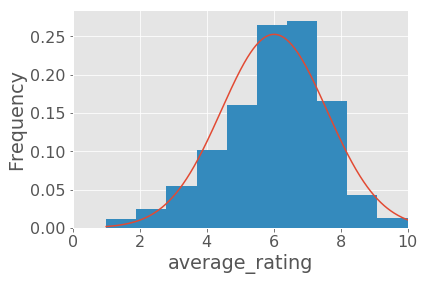

In [38]:
import scipy.stats as stats
h = sorted(board_games["average_rating"])
fit = stats.norm.pdf(h, mean_rating, std_rating)  #this is a fitting 

plt.plot(h,fit,'-')

plt.hist(h,normed=True)      #use this to draw histogram of your data


# plot histogram of average rating
#plt.hist(board_games["average_rating"])
plt.ylabel('Frequency')
plt.xlabel('average_rating')
plt.xlim([0,10])
plt.show()

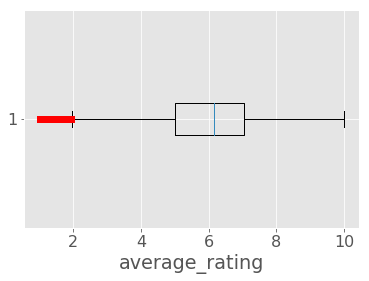

In [39]:
plt.figure()
plt.boxplot(board_games["average_rating"], 0, 'rs', 0)
plt.xlabel('average_rating')
plt.show()

## Feature Engineering

Finding correlations will enable us to remove columns that don't add much predictive power to the model. For example, columns that are uncorrelated with the target won't help a linear regression model. It will also enable us to remove columns that are derived from the target, or otherwise cause overfitting. The steps below help us finding and analyzing correlations:

1. Extract the numeric columns of board_games, and assign to the variable numeric_columns (Leave out name, type, and id.)

2. Use the DataFrame.corr() method to compute pairwise correlations between only the numeric columns. Assign the result to correlations.

3. Display the average_rating column of correlations, which shows how much the other columns correlate with the average_rating column.

4. Remove any columns that seem to be derived from the average_rating. The bayes_average_rating is an example of this.

5. Remove any columns that don't seem to correlate at all with the average_rating column.

In [40]:
# Retain only numeric data
cols = list(board_games.columns)
cols.remove("name")
cols.remove("id")
cols.remove("type")

numeric = board_games[cols]
correlations = numeric.corr()
correlations["average_rating"]

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

The yearpublished column is surprisingly highly correlated with average_rating, showing that more recent games tend to be rated more highly. Games for older players (minage is high) tend to be more highly rated. The more "weighty" a game is (average_weight is high), the more highly it tends to be rated.

In [41]:
# Remove highly correlated columns

cols.remove("bayes_average_rating")

# remove weights as they are not the feature of the games, but user given
cols.remove("total_weights")
cols.remove("average_weight")


# Optional Add new features
# player_range (maxplayers - minplayers)
# playing_time_range (maxplaytime - minplaytime)

## KMeans Clustering

We can first use the sklearn.cluster.KMeans class to fit a k-means clustering model. This class only works with numeric columns, so we have to extract the numeric columns of board_games before passing them into the KMeans.fit() method.

1. Initialize the KMeans class with 3 clusters.
2. Fit the KMeans class to numeric_columns using the fit method.
3. Extract the labels_ attribute of the KMeans class, and assign to the variable labels.

In this data set, using mean squared error as an error metric makes sense. This is because the data is continuous, and follows a somewhat normal distribution. We'll be able to compare our error to the standard deviation to see how good the model is at predictions.

In [48]:
from sklearn.cluster import KMeans

cols.remove("average_rating")
# Instantiate an instance of KMeans
clus = KMeans(n_clusters=3)

# Fit the data 
clus.fit(numeric)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Plot out the cluster assignments.

1. Use the apply method on numeric_columns with the keyword argument axis set to 1 to find the mean of each row. Assign the result to game_mean.

2. Use the apply method on numeric_columns with the keyword argument axis set to 1 to find the standard deviation of each row. Assign the result to game_std.

3. Create a plot using the matplotlib scatter function, with the c keyword argument set to labels, the keyword argument x set to game_mean, and the keyword argument y set to game_std.

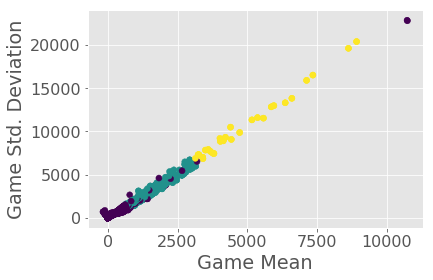

In [49]:
# Mean and std. dev across each row
game_mean = numeric.apply(np.mean, axis=1)
game_std = numeric.apply(np.std, axis=1)

# Obtain labels from the previous step clustering
labels = clus.labels_

#Plot the mean and std. dev according to the cluster color
plt.scatter(x=game_mean, y=game_std, c=labels)
plt.ylabel('Game Std. Deviation')
plt.xlabel('Game Mean')
plt.show()

It looks like most of the games are similar, but as the game attributes tend to increase in value (such as number of users who rated), there are fewer high quality games. So most games don't get played much, but a few get a lot of players.

## Training a Model and Making Predictions

Now that we're done exploring the data, we're ready to create a linear regression model and make predictions for newly created board games. Steps below:

1. Initialize a LinearRegression model, and assign it to the variable reg.
2. Use the LinearRegression.fit() method to set the predictor columns you want the model to use and set the target column to average_rating.
3. Use the LinearRegression.predict() method to make predictions using the columns of board_games that should be used as predictors.
    - The predictors you pass into LinearRegression.predict( ) should be the same predictors you passed into LinearRegression.fit.
    - Assign the result to predictions.

In [56]:
# Machine Learning
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression

# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(board_games[cols], board_games["average_rating"], test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  45515 11379


In [57]:
# Train
clf = LinearRegression()
clf.fit(X_train,y_train)

# Predict
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.0912289797957
